# O(DACS) Hackathon Day 1

Image Classification: classify images of insects into 5 different groups

In [33]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import glob

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
print(tf.__version__)

2.11.0


## Import and explore data

In [36]:
# get data from google drive
# unzip data 
import zipfile

with zipfile.ZipFile("/content/drive/MyDrive/odacs/TRAINING_SET.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive/odacs/data")

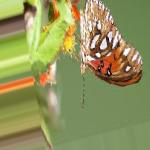

In [37]:
import pathlib
data_dir = "/content/drive/MyDrive/odacs/data"
data_dir = pathlib.Path(data_dir)

butter = list(data_dir.glob('Butterfly/*'))
dragon = list(data_dir.glob('Dragonfly/*'))
grass = list(data_dir.glob('Grasshopper/*'))
lady = list(data_dir.glob('Ladybird/*'))
mosq = list(data_dir.glob('Mosquito/*'))

PIL.Image.open(str(butter[0]))


In [38]:
# check number of images per class
for i in [butter, dragon, grass, lady, mosq]:
    print(len(i))

3111
3250
3285
3258
2933


The number of images per class seems quite balanced, but it might be beneficial to balance it. 

### Define parameters and train/test split

In [39]:
# define params
batch_size = 32 # how many images per batch
img_height = 150 # pixel hight of image
img_width = 150 # pixel width of image

# define training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  labels='inferred',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15837 files belonging to 5 classes.
Using 12670 files for training.


In [40]:
# define validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15837 files belonging to 5 classes.
Using 3167 files for validation.


In [41]:
class_names = train_ds.class_names
print(class_names)

['Butterfly', 'Dragonfly', 'Grasshopper', 'Ladybird', 'Mosquito']


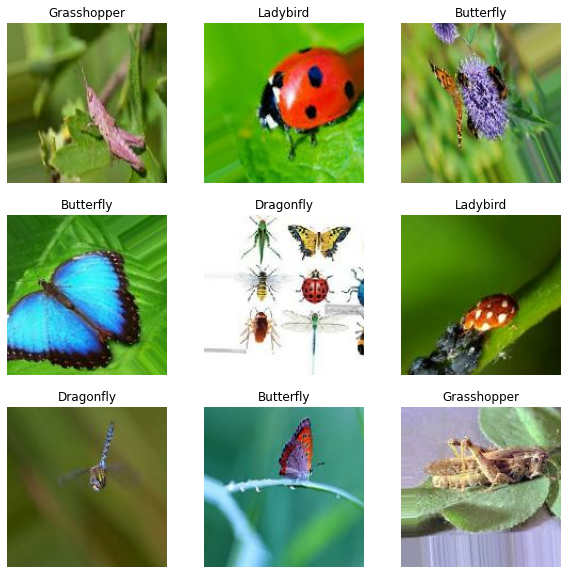

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [43]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 150, 150, 3)
(32,)


We see that we have 32 images per batch, with a dimension of 150x150 pixels, and 3 arrays (R,G,B)

# Model 1
The first model is a vanilla model, using 3 convolutional layers and 3 maxpooling layers

## Define model

In [44]:
# get number of classes
num_classes = len(class_names)

# define model itself
model = Sequential([

  # rescale the images (normalize RGB values)
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  # convolution and Maxpooling layers
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [45]:
# compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [46]:
# see model summary
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 75, 75, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 37, 37, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 37, 37, 64)       

## Run model

In [47]:
# run the model
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
396/396 [==============================] - 29s 69ms/step - loss: 1.2936 - accuracy: 0.4564 - val_loss: 1.1351 - val_accuracy: 0.5466
Epoch 2/10
396/396 [==============================] - 28s 69ms/step - loss: 1.0460 - accuracy: 0.5863 - val_loss: 1.0388 - val_accuracy: 0.5804
Epoch 3/10
396/396 [==============================] - 28s 70ms/step - loss: 0.9076 - accuracy: 0.6436 - val_loss: 1.0364 - val_accuracy: 0.6116
Epoch 4/10
396/396 [==============================] - 27s 68ms/step - loss: 0.7512 - accuracy: 0.7061 - val_loss: 1.0483 - val_accuracy: 0.6034
Epoch 5/10
396/396 [==============================] - 27s 68ms/step - loss: 0.5716 - accuracy: 0.7834 - val_loss: 1.1715 - val_accuracy: 0.6104
Epoch 6/10
396/396 [==============================] - 27s 68ms/step - loss: 0.4030 - accuracy: 0.8516 - val_loss: 1.4345 - val_accuracy: 0.6012
Epoch 7/10
396/396 [==============================] - 27s 68ms/step - loss: 0.2806 - accuracy: 0.8992 - val_loss: 1.6107 - val_accuracy:

## Evaluate the model

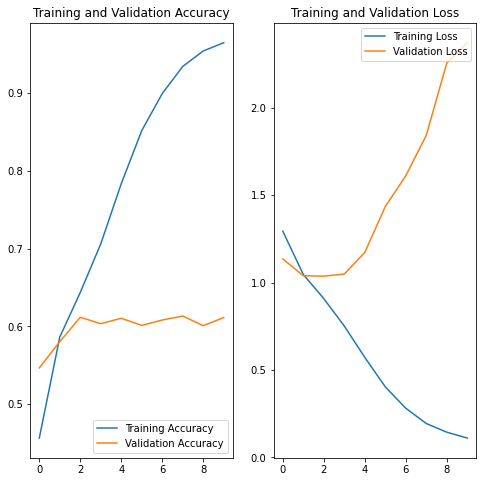

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.save('model_1')

# Model 2
In the 2. model, we add  dropout, to avoid overfitting

dropout randomly sets some nodes to 0

## Define model

In [49]:
# define model itself
model = Sequential([
  # rescale the images (normalize RGB values)
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  # 3 convolution and Maxpooling layers
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  # added dropout layer (randomly sets x % of nodes to 0)
  layers.Dropout(0.2),

  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [50]:
# compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [51]:
# see model summary
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 75, 75, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 37, 37, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 37, 37, 64)       

## Run model

In [52]:
# run the model
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
396/396 [==============================] - 30s 69ms/step - loss: 1.2649 - accuracy: 0.4804 - val_loss: 1.0890 - val_accuracy: 0.5734
Epoch 2/15
396/396 [==============================] - 28s 70ms/step - loss: 1.0506 - accuracy: 0.5917 - val_loss: 0.9928 - val_accuracy: 0.6097
Epoch 3/15
396/396 [==============================] - 28s 71ms/step - loss: 0.9127 - accuracy: 0.6451 - val_loss: 0.9674 - val_accuracy: 0.6249
Epoch 4/15
396/396 [==============================] - 29s 71ms/step - loss: 0.7783 - accuracy: 0.6986 - val_loss: 1.0588 - val_accuracy: 0.6170
Epoch 5/15
396/396 [==============================] - 28s 69ms/step - loss: 0.6224 - accuracy: 0.7674 - val_loss: 1.0829 - val_accuracy: 0.6315
Epoch 6/15
396/396 [==============================] - 28s 70ms/step - loss: 0.4643 - accuracy: 0.8279 - val_loss: 1.1643 - val_accuracy: 0.6312
Epoch 7/15
396/396 [==============================] - 27s 69ms/step - loss: 0.3333 - accuracy: 0.8765 - val_loss: 1.3868 - val_accuracy:

## Evaluate the model

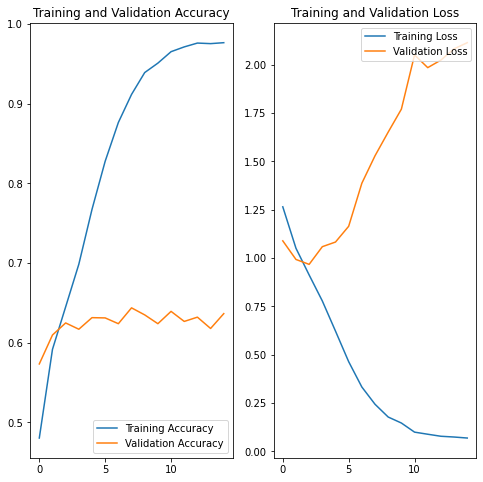

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Model 2 performs a bit better than model 1, due to the added dropout. However, there is still massive overfitting

In [ ]:
model.save('model_2')

# Model 3

## Define model

In [66]:
# define model itself
model = Sequential([

  # rescale the images (normalize RGB values)
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  # convolution and Maxpooling layers
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  # added dropout layer (randomly sets x % of nodes to 0)
  layers.Dropout(0.3),

  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes)
])


In [67]:
# compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [68]:
# see model summary
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_11 (Rescaling)    (None, 150, 150, 3)       0         
                                                                 
 conv2d_39 (Conv2D)          (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 75, 75, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 37, 37, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 37, 37, 64)      

## Run model

In [70]:
# run the model
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
396/396 [==============================] - 30s 68ms/step - loss: 1.3231 - accuracy: 0.4457 - val_loss: 1.1425 - val_accuracy: 0.5384
Epoch 2/10
396/396 [==============================] - 27s 67ms/step - loss: 1.0987 - accuracy: 0.5635 - val_loss: 1.0817 - val_accuracy: 0.5734
Epoch 3/10
396/396 [==============================] - 27s 67ms/step - loss: 0.9669 - accuracy: 0.6242 - val_loss: 0.9763 - val_accuracy: 0.6362
Epoch 4/10
396/396 [==============================] - 45s 114ms/step - loss: 0.8274 - accuracy: 0.6794 - val_loss: 1.0278 - val_accuracy: 0.6299
Epoch 5/10
396/396 [==============================] - 27s 67ms/step - loss: 0.6728 - accuracy: 0.7434 - val_loss: 1.0720 - val_accuracy: 0.6145
Epoch 6/10
396/396 [==============================] - 28s 70ms/step - loss: 0.5319 - accuracy: 0.8002 - val_loss: 1.2492 - val_accuracy: 0.6116
Epoch 7/10
396/396 [==============================] - 27s 67ms/step - loss: 0.4048 - accuracy: 0.8509 - val_loss: 1.3486 - val_accuracy

## Evaluate the model

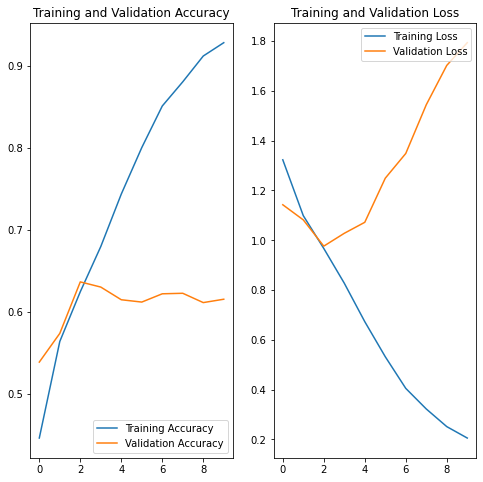

In [72]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.save('model_3')

# Model 5
Try with data augumentation

## Define model

In [71]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
  ]
)

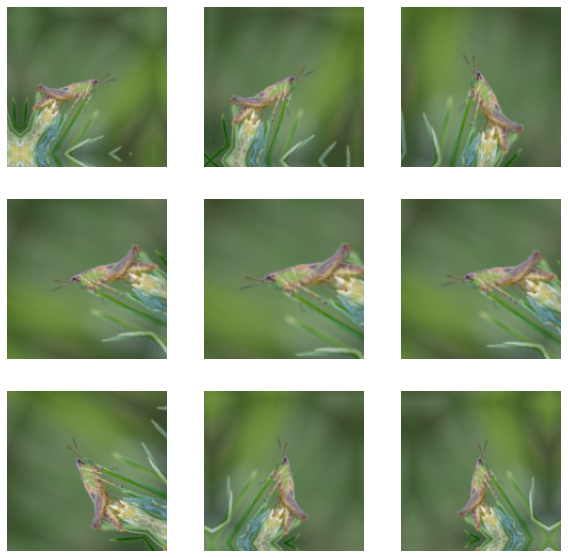

In [73]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [74]:
# define model itself
model = Sequential([
  
  # add data augmentation layer
  data_augmentation,

  # rescale the images (normalize RGB values)
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  # convolution and Maxpooling layers
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  # added dropout layer (randomly sets x % of nodes to 0)
  layers.Dropout(0.2),

  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [75]:
# compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [76]:
# see model summary
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_14 (Sequential)  (None, 150, 150, 3)       0         
                                                                 
 rescaling_12 (Rescaling)    (None, 150, 150, 3)       0         
                                                                 
 conv2d_42 (Conv2D)          (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 75, 75, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 37, 37, 32)       0         
 g2D)                                                

## Run model

In [84]:
# run the model
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
396/396 [==============================] - 77s 195ms/step - loss: 0.5923 - accuracy: 0.7725 - val_loss: 0.9706 - val_accuracy: 0.6561
Epoch 2/5
396/396 [==============================] - 76s 192ms/step - loss: 0.5780 - accuracy: 0.7815 - val_loss: 0.8060 - val_accuracy: 0.7032
Epoch 3/5
396/396 [==============================] - 78s 195ms/step - loss: 0.5623 - accuracy: 0.7856 - val_loss: 1.0086 - val_accuracy: 0.6694
Epoch 4/5
396/396 [==============================] - 77s 192ms/step - loss: 0.5571 - accuracy: 0.7860 - val_loss: 0.9489 - val_accuracy: 0.6801
Epoch 5/5
396/396 [==============================] - 77s 194ms/step - loss: 0.5422 - accuracy: 0.7947 - val_loss: 0.9099 - val_accuracy: 0.6868


## Evaluate the model

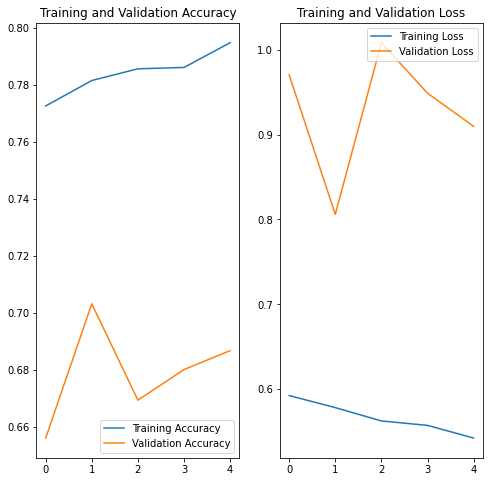

In [85]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [86]:
model.save('/content/drive/MyDrive/odacs/models/model_5_aug_68_acc')

# Model 6
Run gridsearch to do hyperparameter tune

## Define model

In [100]:
batch_size = 32 # how many images per batch

In [101]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
  ]
)

In [102]:
# define model itself
model = Sequential([
  
  # add data augmentation layer
  data_augmentation,

  # rescale the images (normalize RGB values)
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  # convolution and Maxpooling layers
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  # added dropout layer (randomly sets x % of nodes to 0)
  layers.Dropout(0.2),

  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes)
])


In [103]:
# compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [104]:
# see model summary
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_19 (Sequential)  (None, 150, 150, 3)       0         
                                                                 
 rescaling_15 (Rescaling)    (None, 150, 150, 3)       0         
                                                                 
 conv2d_50 (Conv2D)          (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d_47 (MaxPoolin  (None, 75, 75, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_51 (Conv2D)          (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 37, 37, 32)       0         
 g2D)                                                

## Run model

In [ ]:
# run the model
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


396/396 [==============================] - 82s 193ms/step - loss: 1.3202 - accuracy: 0.4466 - val_loss: 1.2776 - val_accuracy: 0.4812
Epoch 2/20
396/396 [==============================] - 77s 193ms/step - loss: 1.1520 - accuracy: 0.5358 - val_loss: 1.0912 - val_accuracy: 0.5756
Epoch 3/20
396/396 [==============================] - 76s 192ms/step - loss: 1.0578 - accuracy: 0.5756 - val_loss: 1.0577 - val_accuracy: 0.5848
Epoch 4/20
396/396 [==============================] - 76s 191ms/step - loss: 1.0266 - accuracy: 0.5937 - val_loss: 1.0301 - val_accuracy: 0.5939
Epoch 5/20
396/396 [==============================] - 77s 195ms/step - loss: 0.9785 - accuracy: 0.6087 - val_loss: 1.0489 - val_accuracy: 0.5952
Epoch 6/20
396/396 [==============================] - 76s 191ms/step - loss: 0.9292 - accuracy: 0.6380 - val_loss: 0.9499 - val_accuracy: 0.6220
Epoch 7/20
105/396 [======>.......................] - ETA: 55s - loss: 0.9175 - accuracy: 0.6432

## Evaluate the model

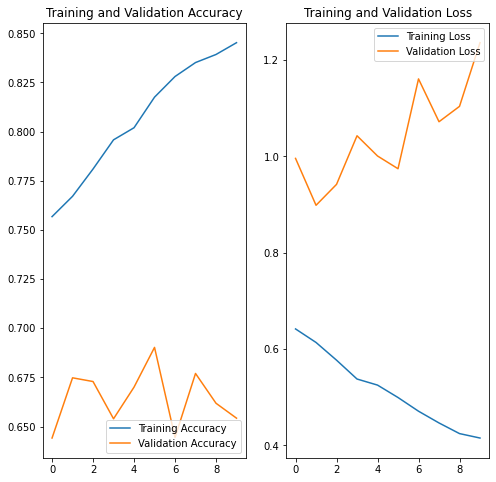

In [95]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/odacs/models/model_5_aug_xx_acc')